# Pyro RL Instance 

Implement a nonlinear simulated reinforcement learning instance in Pyro.

-----
```
author:     Zach Wolpe
email:      zachcolinwolpe@gmail.com
reviewer:   n/a
date:       28 Dec '21
```
-----

In [1]:
import sys
sys.path.append('../process data')
from dependencies import *


# new modules
import statsmodels.nonparametric.smoothers_lowess
from scipy.optimize import minimize

In [17]:
# we will be using a minimization routine, so we return the negative log likelihood


def q_negloglike(params):
    lr=params[0]
    # flexibility in parameter configuration
    if len(params) > 1: temp_t = params[1]
    else:               temp_t = 1
        
    assert resp.shape[0] == reward.shape[0]

    q       = [0.0,0,0]
    ll_sum  = 0
    
    for i in range(resp.shape[0]):
        # log of choice probability (from Daw): β · Qt(ct) − log(exp(β · Qt(L)) + exp(β · Qt(R)))
        ll_sum          += temp_t*q[int(resp[i])] - np.log(np.exp(q[0]*temp_t)+np.exp(q[1]*temp_t))             # log(likelihood)       likelihood == π p(x)
        q[int(resp[i])]  = q[int(resp[i])] + lr*(reward[i]-q[int(resp[i])])                                     # update Q learning
    return -1*ll_sum

# Numerical Optimization Producedure

Min -Log(Likelihood)

Too be supplanted by intelligent optimization schemes.

In [19]:
lrvals      = np.arange(0,1,0.005)                                                # range over alpha
tempvals    = np.arange(0,2,0.01)                                                 # range over beta
ll          = np.zeros((len(lrvals),len(tempvals)))
for lr in tqdm(range(len(lrvals))):
  for t in range(len(tempvals)):
    # find min log-likelihood over range
    ll[lr,t] = q_negloglike([lrvals[lr],tempvals[t]])



100%|██████████| 200/200 [01:29<00:00,  2.23it/s]


parameter values (estimated/true):
learning rate: 0.145/0.100
temperature: 0.770/1.000


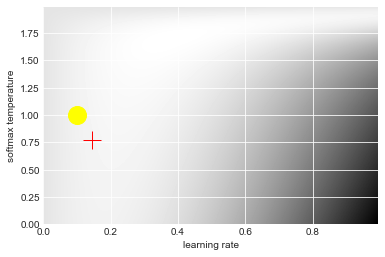

In [20]:
# vis
plt.imshow(-1*ll,aspect='auto',cmap='gray',
           extent=[np.min(lrvals),np.max(lrvals),np.min(tempvals),np.max(tempvals)])
plt.xlabel('learning rate')
plt.ylabel('softmax temperature')
plt.plot(learning_rate,temp,marker='o',markersize=18,color='yellow')
maxloc=np.where(ll==np.min(ll))
plt.plot(lrvals[maxloc[0][0]],tempvals[maxloc[1][0]],marker='+',markersize=18,color='red')
#plt.plot(loglike[80,:10])
print('parameter values (estimated/true):')
print('learning rate: %0.3f/%0.3f'%(lrvals[maxloc[0][0]],learning_rate))
print('temperature: %0.3f/%0.3f'%(tempvals[maxloc[1][0]],temp))


Let's generate a bunch of datasets and look at how well the model fits. for each model, compute estimates using multiple starting points (randomly chosen within the allowable range of parameter values)

In [21]:
# function to perform maximum likelihood estimation 

def ml_est(start=None):
    if not start: start     = [1e-3]
    result                  = minimize(q_negloglike, start, bounds=[[0,1]])
    if result['success']:   return result['x']
    else:                   return [np.nan]

In [23]:
# compute n models with unique parameter sets 
nruns   = 100
est     = np.zeros(nruns)
lrate   = np.zeros(nruns)

for r in tqdm(range(nruns)):
    lrate[r]            = np.random.rand()*0.2 + 0.05
    resp,reward,_,_,_   = generate_data(learning_rate=lrate[r],temp=1.0)
    mle = ml_est()
    if np.isnan(mle[0]): nanctr += 1
    est[r] = mle

100%|██████████| 100/100 [00:06<00:00, 16.35it/s]


0.8685244590790132

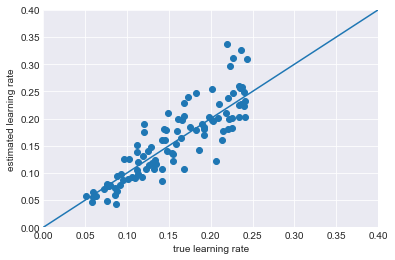

In [24]:
plt.scatter(lrate,est)
plt.xlabel('true learning rate')
plt.ylabel('estimated learning rate')
plt.axis([0,0.4,0,0.4])
plt.plot([0,0.4],[0,0.4])
np.corrcoef(lrate,est)[0,1]

# Bayesian Reinforcement Learning ***

By posing Reinforcement Learning (RL) as a (nonlinear) probabilistic graphical model one can rely on robust, statistical theory to perform inference. Further, this allows for a natural extention to Bayesian RL models.

Here we illustrate computing RL an RL model as a special case of probabilistic programming (Bayesian PGMs).

In [27]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc


# set up imports
import statsmodels.nonparametric.smoothers_lowess
from scipy.optimize import minimize



import pyro
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.0')

pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format='%(message)s', level=logging.INFO)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

## Data Generating Process

For the purpose of illstration we simulate RL data with a known underlying DGP. 


### RL Utility

RL is particularly appealing in modeling the underlying data generating process of some nonstationary temporal sequence. Beyond analogous optimization algorithms - like evolutionary & generic algorithms - RL boasts two advantages:

1. The model may extend beyond the training evironment if the new evironment is assumed to follow the same underlying structure.
2. When using RL models we are frequently interesting in the state-value approximations at some time $t$ and not only the convergent optima.

RL has the potential to revolutionize a plethora of open research questions in human cognition, robotics & adaptive systems. 

### Example: Beach vs Write Software

Note: this instance here is applicable to any dichotomous environment & readily extended.


## Material

- [Bayesian Hierarchical Linear Regression](https://num.pyro.ai/en/stable/tutorials/bayesian_hierarchical_linear_regression.html#2.-Modelling:-Bayesian-Hierarchical-Linear-Regression-with-Partial-Pooling)
- [STAN RL model](https://osf.io/2n39b/)
- [Fitting RL model](https://notebook.community/poldrack/jdm/reinforcement-learning/RL-fitting)
- [Mutli-level models in STAN](https://mc-stan.org/users/documentation/case-studies/radon.html)
- [Except](https://docs.python.org/3/library/exceptions.html)
- [STAN user guide](https://mc-stan.org/docs/2_28/stan-users-guide/hierarchical-logistic-regression.html)
- [Pyro Distributions](https://docs.pyro.ai/en/stable/distributions.html)
- [Pyro Logit](https://github.com/ratschlab/projects2019-boosting-bbvi-pyro/issues/7)

In [28]:
# Data generating process ---------------------------------------------------------------------------------------------------------------------------*


# softmax: P(a|Q)
def softmax(q, temp):
    p= np.exp(q[0]/temp)/(np.exp(q[0]/temp)+np.exp(q[1]/temp))
    if p > np.random.rand():    return 0
    else:                       return 1



# generate probabilistic outcomes (p_A=?)
# p_A is probability of reward for outcome 1
def outcome(resp, correct, prob=0.75):
    if np.random.rand() < prob: rewarded_outcome = correct
    else:                       rewarded_outcome = np.abs(1-correct)
    if resp == rewarded_outcome:    return 1
    else:                           return 0


# function to generate correct responses ---> OBSERVED DATA! 
def get_correct_resp(ntrials=1000, nswitch=50):
    correct_resp = np.zeros(ntrials)
    # switch every 50 trials
    for i in range(0, ntrials, nswitch*2):
        correct_resp[i:(i+nswitch)] = 1
    return correct_resp


# forward model to generate data using q-learning
# TEMP=BETA
# LEARNING RATE = ALPHA

# vector of Q values
def generate_data(learning_rate=0.1, temp=1, prob=0.8):

    correct_resp    = get_correct_resp()
    ntrials         = len(correct_resp)
    q               = np.zeros((ntrials,2))
    resp            = np.zeros(ntrials)
    reward          = np.zeros(ntrials)
    

    # update Q values in accordance with data! want to learn the learning rates !!! 
    for i in range(ntrials):
        if i==0: q[i,:] = np.array([0,0])
        else:
            q[i,:]          = q[i-1,:]
        resp[i]             = softmax(q[i,:], temp)                                                     # return action (1 or 0) p(A|beta,Q)
        reward[i]           = outcome(resp[i], correct_resp[i], prob)                                   # sample (probabilistic) reward
        q[i,int(resp[i])]   = q[i,int(resp[i])] + learning_rate*(reward[i]-q[i,int(resp[i])])           # update Q values

    return resp, reward, q, learning_rate, temp


# Data generating process ---------------------------------------------------------------------------------------------------------------------------*

Text(0, 0.5, 'Q values')

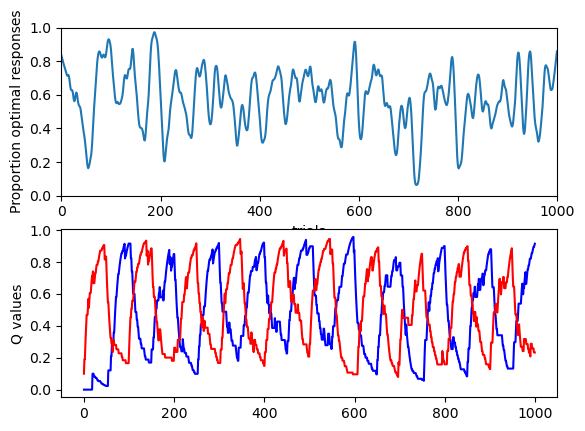

In [30]:
# Vis: DGP ------------------------------------------------------------------------------------------------------------------------------------------*

# generate data
resp,reward,q,learning_rate,temp = generate_data(prob=0.9)
correct= resp==get_correct_resp()

plt.subplot(2,1,1)
smooth=statsmodels.nonparametric.smoothers_lowess.lowess(correct, np.arange(resp.shape[0]),frac=0.02)
plt.plot(smooth[:,1])
plt.axis([0,1000,0,1])
plt.xlabel('trials')
plt.ylabel('Proportion optimal responses')
plt.subplot(2,1,2)
plt.plot(q[:,0],'blue')
plt.plot(q[:,1],'red')
plt.ylabel('Q values')

# Vis: DGP ------------------------------------------------------------------------------------------------------------------------------------------*

Now, we want to fit a model to the behavior above. It is challenging to estimate both the learning rate and temperature parameters, so we will just fix temperature and estimate learning rate. We first need to implement the likelihood function for the Q-learning model.


$$\alpha = learning \ rate$$


$$\beta = softmax \ temporature$$


**Traditional method:**

1. specify - log likelihood
2. minimize over range 

**Probabilistic Inference:**

1. specify $model()$
2. specify $guide()$ function
3. optimize parameters

=====
# Pyro Logistic Regression

https://pyro.ai/examples/bayesian_regression.html

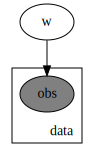

In [49]:
# Encoding ------------------------------------------------------------------------------------------------------------------------------------------*

# OBSERVED DATA
# ACTION:       ---> resp
# REWARD:       ---> reward

# TRAINABLE PARAMETERS
# alpha:        ---> learning_rate
# beta:         ---> temp

# UNKNOWN
# Qt(A)         ---> q[a]

# Encoding ------------------------------------------------------------------------------------------------------------------------------------------*


# vectorize data 
len(resp), len(reward)

# train = torch.tensor(df.values, dtype=torch.float)
import pyro.distributions as dist
import pyro.distributions.constraints as constraints


# def RL_model(actions, rewards):

#     # define parameters
#     alpha   = pyro.param('alpha', lambda: torch.randn(()))
#     alpha = 0.1
#     beta    = pyro.param('beta',  lambda: torch.randn(()))


#     # compute sequence
#     Q = [0,0]



    
#     result = torch.empty_like(actions)
#     for i in range(len(actions)):
#         # update Q 
#         Q[int(actions[i])] = Q[int(actions[i])] + alpha * (rewards[i] - Q[int(actions[i])])
#         sigmoid = torch.sigmoid(torch.matmul(torch.tensor(input_data).double(),torch.tensor(w).double())) 
#        obs = pyro.sample('obs', dist.Bernoulli(sigmoid), obs=observations) 
#         result[i] = pyro.sample(f"obs_{i}", dist.Normal(mean, sigma), obs=log_gdp[i] if log_gdp is not None else None)
#     return result

# pyro.render_model(RL_model, model_args=(resp, reward))
  




def logistic_regression_model(observations, input_data):
    w = pyro.sample('w', dist.MultivariateNormal(torch.zeros(input_data.shape[1]), torch.eye(input_data.shape[1])))
    with pyro.plate("data", input_data.shape[0]):
      sigmoid = torch.sigmoid(torch.matmul(input_data, w.double()))
      obs = pyro.sample('obs', dist.Bernoulli(sigmoid), obs=observations)


pyro.render_model(logistic_regression_model, model_args=(torch.tensor(resp), torch.tensor(q)))


In [52]:
def guide(observations, input_data, index): 
    variance_q = pyro.param('variance_{}'.format(index), torch.eye(input_data.shape[1]), constraints.positive) 
    #variance_q = torch.eye(input_data.shape[1]) 
    mu_q = pyro.param('mu_{}'.format(index), torch.rand(input_data.shape[1])) 
    pyro.sample("w", dist.MultivariateNormal(mu_q, variance_q)) 


adam = pyro.optim.Adam({"lr": 0.02})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(logistic_regression_model, guide, adam, elbo)

Elbo loss: 693.9100079988036
Elbo loss: 666.7912245093598
Elbo loss: 667.0791590818476
Elbo loss: 667.2176525575734
Elbo loss: 668.4299430724941
Elbo loss: 668.5554164360608
Elbo loss: 667.2352910503148
Elbo loss: 667.2699562925319
Elbo loss: 667.0893864839271
Elbo loss: 666.1823729186546


CPU times: user 1.31 s, sys: 1.88 s, total: 3.19 s
Wall time: 1.12 s


Text(0, 0.5, 'ELBO loss')

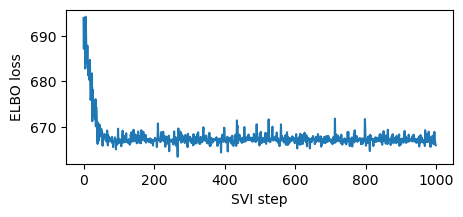

In [57]:
%%time
pyro.clear_param_store()

# These should be reset each training loop.
auto_guide = pyro.infer.autoguide.AutoNormal(logistic_regression_model)
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(logistic_regression_model, auto_guide, adam, elbo)

losses = []
for step in range(1000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step(torch.tensor(resp), torch.tensor(q))
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [55]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoNormal.locs.w [-0.9904375  1.0259717]
AutoNormal.scales.w [0.11391473 0.12034668]


In [58]:
with pyro.plate("samples", 800, dim=-1):
    samples = auto_guide(torch.tensor(resp), torch.tensor(q))

# gamma_within_africa = samples["bR"] + samples["bAR"]
# gamma_outside_africa = samples["bR"]

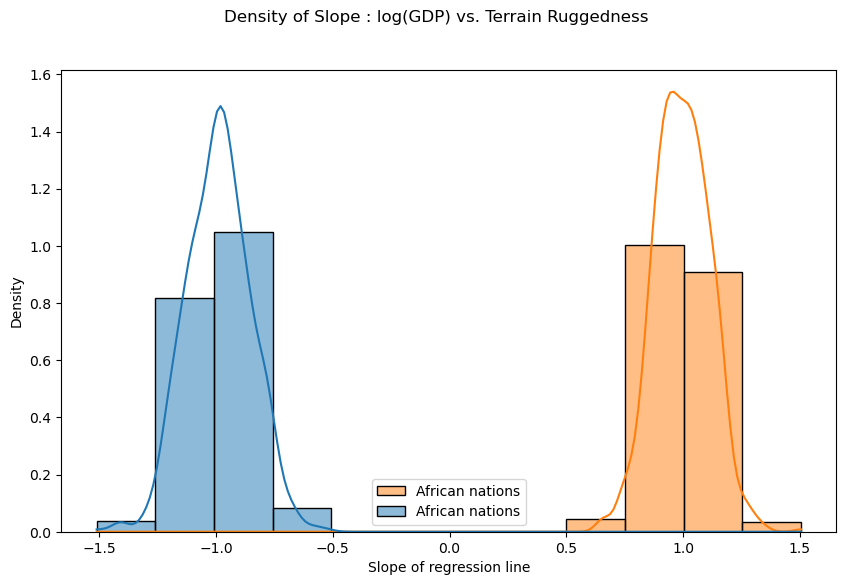

In [63]:


fig = plt.figure(figsize=(10, 6))
sns.histplot(samples['w'].detach().cpu().numpy(), kde=True, stat="density", label="African nations")
# sns.histplot(gamma_outside_africa.detach().cpu().numpy(), kde=True, stat="density", label="Non-African nations", color="orange")
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");
plt.xlabel("Slope of regression line")
plt.legend()
plt.show()